In [1]:
#!pip install --upgrade pip

In [2]:
#!pip install opencv-contrib-python-headless

In [3]:
#!pip install fastparquet

In [4]:
import cv2
import numpy as np
import os, sys
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix,classification_report

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from graphUtils import (
    show_pie,
    show_lines,
    show_pca_variance_graph,
    show_pca_correlation_graph,
    show_scatter_graph,
    show_cols_boxplots_by_col,
    view_clustered_heatmap,
)
import plotly.io as pio

import matplotlib.pyplot as plt
import seaborn as sns

pio.renderers.default = "iframe"
import glob

In [5]:
df = pd.read_csv('dataImage.csv')

In [6]:
df.head()

,uniq_id,image,product_category_level_1,labelNb
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,0
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,1
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,1
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,0
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,0


# Lecture et détection des features de tous les produits

In [7]:
sift = cv2.SIFT_create()

In [8]:
all_descriptors = []
nb_done = 0
image_keypoints = {}
image_descriptors = {}

for uniq_id in df["uniq_id"]:
    img = cv2.imread(f"./Images/{uniq_id}.jpg", cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    if descriptors is None:
        print(f"pb avec fichier {uniq_id}.jpg")
        continue
    image_keypoints[uniq_id] = keypoints
    image_descriptors[uniq_id] = descriptors
    
    for descriptor in descriptors:
        all_descriptors.append(descriptor)
    nb_done += 1
    if nb_done % 100 == 0:
        print(f"Done {nb_done}")

Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Done 1000


In [9]:
len(all_descriptors)

9051350

In [10]:
all_unique_descriptors = np.unique(all_descriptors, axis=0)

In [11]:
all_unique_descriptors.shape

(9005634, 128)

## Visualisation des features

In [12]:
uniq_id0 = df.iloc[510]["uniq_id"]
print(len(image_keypoints[uniq_id0]))

1762


In [13]:
uniq_id1 = df.iloc[3]["uniq_id"]
print(len(image_keypoints[uniq_id1]))

11754


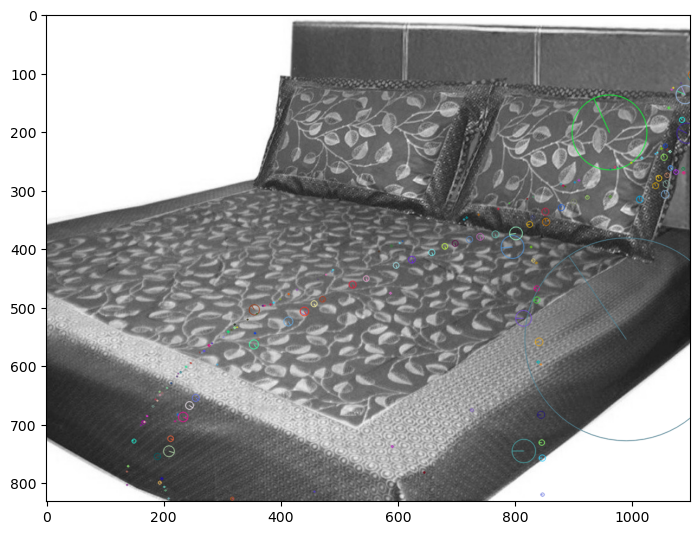

In [14]:
img = cv2.imread(f"./Images/{uniq_id1}.jpg", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(img.shape[0]/100,img.shape[1]/100))

output_image=cv2.drawKeypoints(img,image_keypoints[uniq_id0],0,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(output_image)
plt.show()

# Clustering KMeans des descripteurs

In [15]:
uniq_id0 = df.iloc[0]["uniq_id"]
image_descriptors[uniq_id0].shape

(98204, 128)

In [16]:
min_descriptors = len(image_descriptors[uniq_id0])
max_descriptors = len(image_descriptors[uniq_id0])
for uniq_id in image_descriptors.keys():
    min_descriptors = min(min_descriptors, len(image_descriptors[uniq_id]))
    max_descriptors = max(max_descriptors, len(image_descriptors[uniq_id]))
print(min_descriptors, max_descriptors)

114 433180


Chaque image a un nombre de descripteurs différents (entre 114 et 433180) qui sont des vecteurs de dimension 128. Il y a en tout 9005630 differents descripteurs d'images. 

Il est donc impossible de travailler directement sur les descripteurs extraits des differentes images.

Nous allons plutot tenter de regrouper les features dans des Bags of Words. Pour cela:
- nous effectuons un clustering sur les descripteurs : comme nous savons que nous avons 7 catégories au départ, nous allons faire un clustering avec 700 clusters
- nous allons ensuite réaliser un histogramme pour chaque cluster trouvé: pour chaque image (article), nous allons compter le nombre de descripteurs dans chacun des clusters trouvés. Comme nous avons un nombre de clusters différent pour chaque image, nous normalisons en additionnant l'inverse du nombre total de descripteur dans l'image.
- nous pouvons alors travailler sur les colonnes des clusters trouvés et leurs valeurs (PCA, tSNE)

In [17]:
k = 7 * 100

In [18]:
len(all_descriptors[0])

128

In [19]:
batch_size = np.size(os.listdir("./Images"))*3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=0, n_init="auto").fit(all_descriptors)

le nombre de clusters n'est pas nécessairement le même que le nombre de descripteurs ou le nombre de caractéristiques d'une image. En fait, dans la plupart des scénarios d'utilisation du "Sac de Mots Visuels" (Bag of Visual Words, BoVW), le nombre de clusters est nettement inférieur au nombre total de descripteurs extraits de toutes les images.

Pour clarifier :

Descripteurs :

Lorsque vous utilisez un algorithme comme SIFT sur une image, vous obtenez plusieurs descripteurs. Chaque descripteur est généralement un vecteur de dimension 128 pour SIFT.
Si vous avez une collection d'images, vous obtiendrez des millions (ou plus) de ces descripteurs.

Clustering (k-means en l'occurrence) :

Une fois que vous avez extrait tous ces descripteurs de toutes les images, vous utilisez un algorithme de clustering (comme k-means) pour les regrouper en "clusters".
Le centre de chaque cluster (ou centroid) peut être considéré comme un "mot visuel".
Le nombre de clusters (ou k dans k-means) est un hyperparamètre que vous choisissez. Il détermine le nombre de "mots visuels" dans votre "vocabulaire".

Histogrammes :

Pour chaque image, vous comptez combien de ses descripteurs tombent dans chacun de ces clusters et créez un histogramme.
La dimension de cet histogramme est égale au nombre de clusters (ou "mots visuels").
Pour donner un exemple simple : Si vous avez 1000 images et que vous extrayez 100 000 descripteurs de ces images, vous pourriez choisir de les regrouper en, disons, 500 clusters. Chaque image serait alors représentée par un histogramme de taille 500, où chaque valeur de l'histogramme indique combien de descripteurs de l'image tombent dans chacun des 500 clusters.

In [20]:
kmeans.predict([all_descriptors[1]])

array([67])

Ajoutons au dataframe les colonnes correspondant aux clusters trouvés à partir des descripteurs des images

In [21]:
drop_cols = []
for c in df.columns:
    if c.startswith("histo_km_"):
        drop_cols.append(c)
        
if len(drop_cols)>0:
    df.drop(columns=drop_cols, inplace=True)
    
for i in range(0,k):
    df = pd.concat([df, pd.Series([0 for j in range(0,k)], name=f"histo_km_{i}")], axis=1)

In [22]:
df.head()

,uniq_id,image,product_category_level_1,labelNb,histo_km_0,histo_km_1,histo_km_2,histo_km_3,histo_km_4,histo_km_5,...,histo_km_690,histo_km_691,histo_km_692,histo_km_693,histo_km_694,histo_km_695,histo_km_696,histo_km_697,histo_km_698,histo_km_699
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
nb_done = 0
for uniq_id in df["uniq_id"]:
    r = {}
    for i in range(0,k): r[f"histo_km_{i}"] = 0.0
        
    k_labels_idx = kmeans.predict(np.array(image_descriptors[uniq_id], dtype=float))
    for i in range(0, len(image_descriptors[uniq_id])):
        k_label_idx = k_labels_idx[i]
        r[f"histo_km_{k_label_idx}"] += 1/len(image_descriptors[uniq_id])

    for i in range(0,k):
        df.loc[df["uniq_id"]==uniq_id, f"histo_km_{i}"] = r[f"histo_km_{i}"]
    nb_done += 1
    if nb_done % 50 == 0:
        print(f"Done {nb_done} rows")

Done 50 rows
Done 100 rows
Done 150 rows
Done 200 rows
Done 250 rows
Done 300 rows
Done 350 rows
Done 400 rows
Done 450 rows
Done 500 rows
Done 550 rows
Done 600 rows
Done 650 rows
Done 700 rows
Done 750 rows
Done 800 rows
Done 850 rows
Done 900 rows
Done 950 rows
Done 1000 rows
Done 1050 rows


In [24]:
df.head()

,uniq_id,image,product_category_level_1,labelNb,histo_km_0,histo_km_1,histo_km_2,histo_km_3,histo_km_4,histo_km_5,...,histo_km_690,histo_km_691,histo_km_692,histo_km_693,histo_km_694,histo_km_695,histo_km_696,histo_km_697,histo_km_698,histo_km_699
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,0,0.006313,0.000102,0.002933,0.000081,0.000886,0.002322,...,0.000234,0.000153,0.000764,0.001568,0.000458,0.000509,0.000234,0.000295,0.000214,0.001843
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,1,0.000042,0.002141,0.001280,0.001280,0.001217,0.000021,...,0.001385,0.000105,0.000336,0.000902,0.003316,0.000818,0.001364,0.000168,0.001175,0.000588
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,1,0.001799,0.000000,0.000112,0.000450,0.000225,0.001349,...,0.001911,0.000112,0.000674,0.001124,0.001237,0.002136,0.000337,0.000000,0.000787,0.001124
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,0,0.000596,0.001531,0.001702,0.000510,0.001276,0.000510,...,0.000936,0.000851,0.001616,0.003063,0.002552,0.000851,0.001276,0.006636,0.001787,0.000510
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,0,0.001973,0.000450,0.001142,0.002665,0.001973,0.000311,...,0.000415,0.000519,0.001280,0.004222,0.000761,0.002388,0.000311,0.000865,0.003392,0.000900


In [25]:
#df.head()

# PCA

In [26]:
cols = [f"histo_km_{i}" for i in range(0,k)]
X = df.loc[:, cols]

pca = PCA(n_components=k)
pca.fit(X)

PCA(n_components=700)

In [27]:
show_pca_variance_graph(pca)

On garde 99% de la variabce totale avec 368 composantes

In [28]:
pca = PCA(n_components=368)
X_pca = pca.fit_transform(X)

In [29]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["product_category_level_1"],
    title="Projection PCA sur les 2 premiers axes",
)

# Comparaison

## Représentation tSNE des features extraites avec la catégorie réelle

In [30]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)

In [31]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["product_category_level_1"],
    title="Projection tSNE des features extraites avec la catégorie",
)

On distingue certaines zones où des categories (watches, beauty and personal cate, home furnishing et home decor & festive needs) se concentrent mais cela reste mélangé dans la représentation tSNE

## Clustering depuis le tSNE

Nous réalisons un clustering Kmeans avec 7 clusters depuis la distribution tSNE. Ceci nous permettra de comparer une distribution claire par rapport à la distribution effectuée avec les catégories.

In [32]:
kmeans2 = KMeans(n_clusters=7, n_init="auto", random_state=0).fit(X_embedded)
df["kmeans2_labels"] = kmeans2.labels_.astype(str)

C:\Users\pouri\anaconda3\envs\mon_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



In [33]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["kmeans2_labels"],
    title="Projection tSNE des features extraites avec le clustering kmeans",
)

In [34]:
adjusted_rand_score(kmeans2.labels_, df["product_category_level_1"])

0.04957791448043776

Le score ARI ajusté est très faible

# Conclusion

## Matrice de confusion

In [35]:
pd.crosstab(df["product_category_level_1"], df["kmeans2_labels"])

kmeans2_labels,0,1,2,3,4,5,6
product_category_level_1,,,,,,,
Baby Care,28,22,5,54,9,17,15
Beauty and Personal Care,33,35,29,11,18,15,9
Computers,10,6,22,18,12,48,34
Home Decor & Festive Needs,25,34,10,28,20,13,20
Home Furnishing,14,46,7,32,30,9,12
Kitchen & Dining,9,13,56,20,14,25,13
Watches,27,11,28,10,43,16,15


En regardant les classes kmeans2_labels majoritaires, on voit les correspondances:

|classe kmeans|classe réelle majoritaire|
|--------------|-------------|
|0|beauty and personal care|
|1|home furnishing|
|2|Baby Care|
|3|Home Decor & Festive Needs|
|4|Watches|
|5|Kitchen & Dining|
|6|Computers|                   

In [36]:
df_cross = pd.crosstab(df["product_category_level_1"], df["kmeans2_labels"])

In [37]:
# Obtenir le nom de la colonne avec la valeur maximale pour chaque ligne
max_columns = pd.crosstab(df["product_category_level_1"], df["kmeans2_labels"]).idxmax(axis=1).tolist()

print(max_columns)

['3', '1', '5', '1', '1', '2', '4']


In [38]:
# Pour chaque colonne, obtenir l'index ayant la valeur maximale
max_indexes = [df_cross[col].idxmax() for col in df_cross.columns]

print(max_indexes)

['Beauty and Personal Care ', 'Home Furnishing ', 'Kitchen & Dining ', 'Baby Care ', 'Watches ', 'Computers ', 'Computers ']


"La fonction parcourt chaque colonne du dataframe, identifie l'index associé à la valeur maximale, et l'ajoute à une liste. Si cet index a déjà été choisi lors de l'analyse d'une colonne précédente, la fonction sélectionne l'index de la deuxième plus grande valeur. Cette approche est particulièrement utile lorsqu'on souhaite identifier des zones où l'algorithme a potentiellement mal classé ou prédit les données, en mettant en avant les cas où un certain index est fréquemment choisi comme le plus important."

In [39]:
# Initialiser une liste pour stocker les indexs
max_indexes2 = []

# Boucle pour obtenir l'index du max (ou du deuxième max si le premier est déjà pris)
for col in df_cross.columns:
    # Trier la colonne dans l'ordre décroissant
    sorted_col = df_cross[col].sort_values(ascending=False)
    
    # Si le premier élément (max) n'est pas déjà dans la liste, l'ajouter
    if sorted_col.index[0] not in max_indexes2:
        max_indexes2.append(sorted_col.index[0])
    # Sinon, ajouter le deuxième élément
    else:
        max_indexes.append(sorted_col.index[1])

print(max_indexes2)

['Beauty and Personal Care ', 'Home Furnishing ', 'Kitchen & Dining ', 'Baby Care ', 'Watches ', 'Computers ']


In [40]:
df["category_pred"] = ""

In [41]:
# corr_labels = [
#     "Beauty and Personal Care ",
#     "Home Furnishing ",
#     "Baby Care ",
#     "Home Decor & Festive Needs ",
#     "Watches ",
#     "Kitchen & Dining ",
#     "Computers ",
# ]

corr_labels = max_indexes

In [42]:
for i in range(0, len(corr_labels)):
    df.loc[df["kmeans2_labels"]==f"{i}", "category_pred"] = corr_labels[i]

In [43]:
conf_mat = confusion_matrix(df["product_category_level_1"], df["category_pred"])
conf_mat

array([[54, 28, 32,  0, 22,  5,  9],
       [11, 33, 24,  0, 35, 29, 18],
       [18, 10, 82,  0,  6, 22, 12],
       [28, 25, 33,  0, 34, 10, 20],
       [32, 14, 21,  0, 46,  7, 30],
       [20,  9, 38,  0, 13, 56, 14],
       [10, 27, 31,  0, 11, 28, 43]], dtype=int64)

<Axes: ylabel='product_category_level_1'>

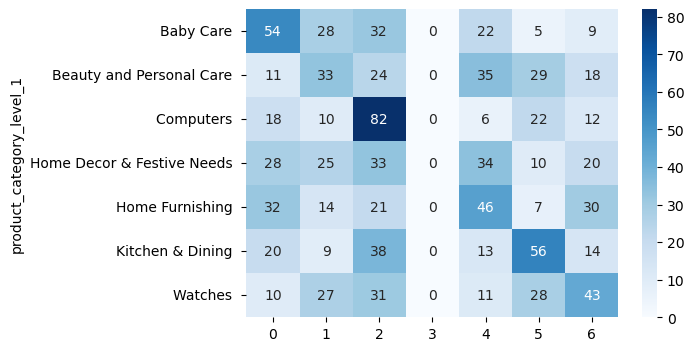

In [44]:
df_cm = pd.DataFrame(conf_mat, index = pd.crosstab(df["product_category_level_1"], df["kmeans2_labels"]).reset_index()["product_category_level_1"],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On détermine assez bien à quels clusters les catégories de produits "baby care", "home decor & festive needs" et "watches" appartiennent.

Par contre pour les catégories "computers", "home furnishing" et "kitchen & dining", nous n'avons aucune certitude tant les valeurs maximales du nombre d'éléments associés aux clusters sont proches.

## Scores de classification

In [45]:
print(classification_report(df["product_category_level_1"], df["category_pred"]))

                             precision    recall  f1-score   support

                 Baby Care        0.31      0.36      0.33       150
  Beauty and Personal Care        0.23      0.22      0.22       150
                 Computers        0.31      0.55      0.40       150
Home Decor & Festive Needs        0.00      0.00      0.00       150
           Home Furnishing        0.28      0.31      0.29       150
          Kitchen & Dining        0.36      0.37      0.36       150
                   Watches        0.29      0.29      0.29       150

                   accuracy                           0.30      1050
                  macro avg       0.25      0.30      0.27      1050
               weighted avg       0.25      0.30      0.27      1050



C:\Users\pouri\anaconda3\envs\mon_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\pouri\anaconda3\envs\mon_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\pouri\anaconda3\envs\mon_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



On voit que les scores F1 les plus élevés correspondent aux catégories "watches", "home decor & festive needs" et "baby care". 
Ces scores restent néanmoins assez bas.

On voit que la sensibilité (capacité à detecter les éléments d'une classe définie) la plus faible correspond à la catégorie "Beauty and Personal Care", suivie de la catégorie "Home Decor & Festive Needs" et "Home Furnishing", ce qui expliquent les doutes exprimés avec la matrice de confusion.